In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sn
import re

import tensorflow as tf 
import tensorflow.keras as keras 
import tensorflow_addons  as tfa

import sklearn.model_selection as model_selection
import sklearn.metrics as metrics_model
import sklearn.linear_model as linear_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/glove.6B.zip

Archive:  /content/drive/MyDrive/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [2]:
import re
def remove_hash(data):
  return re.sub('#','',data)

In [3]:
train_set=pd.read_csv('/content/drive/MyDrive/train_df.csv')
test_set=pd.read_csv('/content/drive/MyDrive/test_df.csv')

train_set['clean_text_1']=train_set['clean_text'].apply(remove_hash)
test_set['clean_text_1']=test_set['clean_text'].apply(remove_hash)

X_train=train_set['clean_text_1'].values
X_test=test_set['clean_text_1'].values
y_train=train_set['NomericSentiment'].values
y_test=test_set['NomericSentiment'].values

X_train,X_val,y_train,y_val=model_selection.train_test_split(X_train,y_train,test_size=0.2,stratify=train_set['NomericSentiment'],random_state=42)

y_train=keras.utils.to_categorical(y_train,5)
y_test=keras.utils.to_categorical(y_test,5)
y_val=keras.utils.to_categorical(y_val,5)

tokinizer=keras.preprocessing.text.Tokenizer(num_words=30000)
tokinizer.fit_on_texts(train_set['clean_text_1'].values)

vocab_size=len(tokinizer.word_index)+1
print(vocab_size)

max_length=70
X_train=tokinizer.texts_to_sequences(X_train)
X_test=tokinizer.texts_to_sequences(X_test)
X_val=tokinizer.texts_to_sequences(X_val)
X_train_set=keras.preprocessing.sequence.pad_sequences(X_train,padding='post',maxlen=max_length)
X_test_set=keras.preprocessing.sequence.pad_sequences(X_test,padding='post',maxlen=max_length)
X_val_set=keras.preprocessing.sequence.pad_sequences(X_val,padding='post',maxlen=max_length)



45832


In [4]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [5]:
embading_index={}
path = '/content/glove.6B.300d.txt'
with open(path) as f:
  for line in f:
    key,value=line.split(maxsplit=1)
    value=np.fromstring(value,"f",sep=" ")
    embading_index[key]=value

print("Found {} word vector".format(len(embading_index)))

embading_dim=300
num_tokens=vocab_size
hit=0
miss=0

embading_matrix=np.zeros((num_tokens,embading_dim))

for word,value in tokinizer.word_index.items():
  embading_vector=embading_index.get(word)
  if embading_vector is not None:
      embading_matrix[value]=embading_vector
      hit+=1
  else:miss+=1
print("Hit : {} ,misses: {}".format(hit,miss))

Found 400000 word vector
Hit : 27022 ,misses: 18809


In [ ]:
f1=tfa.metrics.F1Score(5)

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS=stopwords.words('english')

def remove_stop_word_less_than_3_charecter(data):
  min_stop=[w for w in STOPWORDS if len(w)<=3]
  word=data.split()
  res=[w for w in word if w not in min_stop]
  return ' '.join(res)

def remove_stop_word(data):
  word=data.split()
  res=[w for w in word if w not in STOPWORDS]
  return ' '.join(res)

def remove_hash(data):
  words=data.split()
  res=[w for w in words if '#' not in w]
  return ' '.join(res)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
keras.backend.clear_session()
model=keras.models.Sequential([
          keras.layers.Embedding(input_dim=num_tokens,
                                 output_dim=embading_dim,
                                 embeddings_initializer=keras.initializers.Constant(embading_matrix),
                                 trainable=True,
                                 input_length=max_length),
          keras.layers.Bidirectional(keras.layers.LSTM(128,recurrent_dropout=0.1)),
          keras.layers.Dropout(0.2),
          keras.layers.Dense(64,activation='relu'),
          keras.layers.Dropout(0.3),
          keras.layers.Dense(5,activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 200)           9164400   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               336896    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 9,518,069
Trainable params: 9,518,069
Non-trainable params: 0
______________________________________________

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',f1])

In [ ]:
model_checkpoint=keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/LSTM__128_Node_with_Bidirectional_200d.h5',monitor='val_loss',save_best_only=True)
erlay_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [ ]:
with tf.device('/device:GPU:0'):
  history=model.fit(X_train_set,y_train,epochs=20,validation_data=(X_val_set,y_val),batch_size=64,callbacks=[model_checkpoint,erlay_stop])

Epoch 1/20
412/412 [==============================] - 213s 508ms/step - loss: 1.3831 - accuracy: 0.3838 - f1_score: 0.3641 - val_loss: 0.9163 - val_accuracy: 0.6327 - val_f1_score: 0.6474
Epoch 2/20
412/412 [==============================] - 204s 494ms/step - loss: 0.7395 - accuracy: 0.7264 - f1_score: 0.7331 - val_loss: 0.6989 - val_accuracy: 0.7407 - val_f1_score: 0.7501
Epoch 3/20
412/412 [==============================] - 206s 499ms/step - loss: 0.4888 - accuracy: 0.8373 - f1_score: 0.8414 - val_loss: 0.6730 - val_accuracy: 0.7653 - val_f1_score: 0.7736
Epoch 4/20
412/412 [==============================] - 199s 484ms/step - loss: 0.3486 - accuracy: 0.8941 - f1_score: 0.8970 - val_loss: 0.7194 - val_accuracy: 0.7620 - val_f1_score: 0.7703
Epoch 5/20
412/412 [==============================] - 205s 497ms/step - loss: 0.2721 - accuracy: 0.9123 - f1_score: 0.9152 - val_loss: 0.7762 - val_accuracy: 0.7515 - val_f1_score: 0.7606
Epoch 6/20
412/412 [==============================] - 207s 5

In [ ]:
model=keras.models.load_model('/content/drive/MyDrive/LSTM__1_32_Node_with_Bidirectional_200d.h5')

823/823 [==============================] - 31s 38ms/step - loss: 0.3240 - accuracy: 0.9082 - f1_score: 0.9117
Training Accuracy:0.9082 , f1_score [0.89433074 0.89580745 0.92221373 0.9251132  0.92089826]
258/258 [==============================] - 10s 38ms/step - loss: 0.6619 - accuracy: 0.7690 - f1_score: 0.7755
Testing Accuracy:  0.7690, f1_score [0.7458982  0.7268195  0.8398357  0.79623353 0.7687943 ]


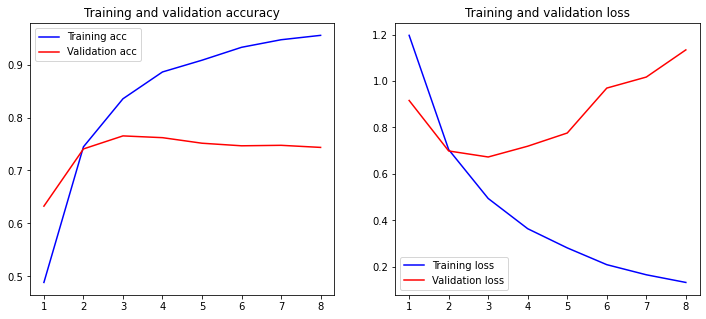

In [ ]:

loss, accuracy ,f1_score = model.evaluate(X_train_set, y_train)
print("Training Accuracy:{:.4f} , f1_score {}".format(accuracy,f1_score))
loss, accuracy ,f1_score = model.evaluate(X_test_set, y_test)
print("Testing Accuracy:  {:.4f}, f1_score {}".format(accuracy,f1_score))
plot_history(history)

we will try remove hash from data

In [ ]:
train_set=pd.read_csv('/content/drive/MyDrive/train_df.csv')
test_set=pd.read_csv('/content/drive/MyDrive/test_df.csv')

train_set['clean_text_1']=train_set['clean_text'].apply(remove_hash).apply(remove_stop_word)
test_set['clean_text_1']=test_set['clean_text'].apply(remove_hash).apply(remove_stop_word)

X_train=train_set['clean_text_1'].values
X_test=test_set['clean_text_1'].values
y_train=train_set['NomericSentiment'].values
y_test=test_set['NomericSentiment'].values


X_train,X_val,y_train,y_val=model_selection.train_test_split(X_train,y_train,test_size=0.2,stratify=train_set['NomericSentiment'],random_state=42)

y_train=keras.utils.to_categorical(y_train,5)
y_test=keras.utils.to_categorical(y_test,5)
y_val=keras.utils.to_categorical(y_val,5)

tokinizer=keras.preprocessing.text.Tokenizer(num_words=30000)
tokinizer.fit_on_texts(train_set['clean_text_1'].values)

vocab_size=len(tokinizer.word_index)+1
print(vocab_size)

max_length=60
X_train=tokinizer.texts_to_sequences(X_train)
X_test=tokinizer.texts_to_sequences(X_test)
X_val=tokinizer.texts_to_sequences(X_val)
X_train_set=keras.preprocessing.sequence.pad_sequences(X_train,padding='post',maxlen=max_length)
X_test_set=keras.preprocessing.sequence.pad_sequences(X_test,padding='post',maxlen=max_length)
X_val_set=keras.preprocessing.sequence.pad_sequences(X_val,padding='post',maxlen=max_length)



33946


In [ ]:
embading_index={}
path = '/content/glove.6B.200d.txt'
with open(path) as f:
  for line in f:
    key,value=line.split(maxsplit=1)
    value=np.fromstring(value,"f",sep=" ")
    embading_index[key]=value

print("Found {} word vector".format(len(embading_index)))

embading_dim=200
num_tokens=vocab_size
hit=0
miss=0

embading_matrix=np.zeros((num_tokens,embading_dim))

for word,value in tokinizer.word_index.items():
  embading_vector=embading_index.get(word)
  if embading_vector is not None:
      embading_matrix[value]=embading_vector
      hit+=1
  else:miss+=1
print("Hit : {} ,misses: {}".format(hit,miss))

Found 400000 word vector
Hit : 26066 ,misses: 7879


In [ ]:
keras.backend.clear_session()
model_1=keras.models.Sequential([
          keras.layers.Embedding(input_dim=num_tokens,
                                 output_dim=embading_dim,
                                 embeddings_initializer=keras.initializers.Constant(embading_matrix),
                                 trainable=True,
                                 input_length=max_length),
          keras.layers.Bidirectional(keras.layers.LSTM(128)),
          keras.layers.Dropout(0.2),
          keras.layers.Dense(5,activation='softmax')
])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 200)           6789200   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               336896    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 7,127,381
Trainable params: 7,127,381
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy',f1])
model_checkpoint=keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/LSTM__64_Node_with_Bidirectional_200d_with_cleanHash_allstop_word.h5',monitor='val_loss',save_best_only=True)
erlay_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [ ]:
with tf.device('/device:GPU:0'):
  history=model_1.fit(X_train_set,y_train,epochs=20,validation_data=(X_val_set,y_val),batch_size=32,callbacks=[model_checkpoint,erlay_stop])

Epoch 1/20
823/823 [==============================] - 63s 73ms/step - loss: 1.2134 - accuracy: 0.4792 - f1_score: 0.6075 - val_loss: 0.7717 - val_accuracy: 0.7124 - val_f1_score: 0.7209
Epoch 2/20
823/823 [==============================] - 62s 76ms/step - loss: 0.5993 - accuracy: 0.7880 - f1_score: 0.7935 - val_loss: 0.6577 - val_accuracy: 0.7648 - val_f1_score: 0.7731
Epoch 3/20
823/823 [==============================] - 61s 74ms/step - loss: 0.3978 - accuracy: 0.8731 - f1_score: 0.8769 - val_loss: 0.6725 - val_accuracy: 0.7679 - val_f1_score: 0.7744
Epoch 4/20
823/823 [==============================] - 61s 74ms/step - loss: 0.2762 - accuracy: 0.9146 - f1_score: 0.9174 - val_loss: 0.7550 - val_accuracy: 0.7644 - val_f1_score: 0.7718
Epoch 5/20
823/823 [==============================] - 61s 74ms/step - loss: 0.1950 - accuracy: 0.9361 - f1_score: 0.9384 - val_loss: 0.9316 - val_accuracy: 0.7495 - val_f1_score: 0.7575
Epoch 6/20
823/823 [==============================] - 61s 74ms/step - 

823/823 [==============================] - 6s 6ms/step - loss: 0.4139 - accuracy: 0.8712 - f1_score: 0.8755
Training Accuracy:0.8712 , f1_score [0.8513802  0.8483876  0.9128378  0.87967175 0.8852459 ]
258/258 [==============================] - 1s 6ms/step - loss: 0.6509 - accuracy: 0.7732 - f1_score: 0.7791
Testing Accuracy:  0.7732, f1_score [0.7520806  0.7092569  0.8597822  0.80312717 0.77124774]


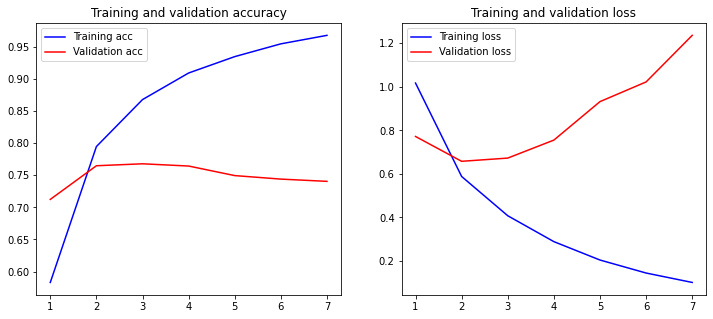

In [ ]:
model=keras.models.load_model('/content/drive/MyDrive/LSTM__64_Node_with_Bidirectional_200d_with_cleanHash_allstop_word.h5')
loss, accuracy ,f1_score = model.evaluate(X_train_set, y_train)
print("Training Accuracy:{:.4f} , f1_score {}".format(accuracy,f1_score))
loss, accuracy ,f1_score = model.evaluate(X_test_set, y_test)
print("Testing Accuracy:  {:.4f}, f1_score {}".format(accuracy,f1_score))
plot_history(history)

if we dont remove stop word its better

In [ ]:
keras.backend.clear_session()
model=keras.models.Sequential([
          keras.layers.Embedding(input_dim=num_tokens,
                                 output_dim=embading_dim,
                                 embeddings_initializer=keras.initializers.Constant(embading_matrix),
                                 trainable=True,
                                 input_length=max_length),
          keras.layers.GRU(64,return_sequences=True),
          keras.layers.Dropout(0.2),
          keras.layers.Conv1D(32,3),
          keras.layers.Dropout(0.2),
          keras.layers.Conv1D(32,3),
          keras.layers.GlobalMaxPool1D(),
          keras.layers.Dense(5,activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 300)           13749600  
_________________________________________________________________
gru (GRU)                    (None, 60, 64)            70272     
_________________________________________________________________
dropout (Dropout)            (None, 60, 64)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 58, 32)            6176      
_________________________________________________________________
dropout_1 (Dropout)          (None, 58, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 56, 32)            3104      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
eraly_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)
check_point=keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/GRU_Conv1D.h5',save_best_only=True)

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
with tf.device('/device:GPU:0'):
  history=model.fit(X_train_set,y_train,epochs=20,validation_data=(X_val_set,y_val),callbacks=[eraly_stop,check_point])

Epoch 1/20
823/823 [==============================] - 108s 130ms/step - loss: 1.2855 - accuracy: 0.4375 - val_loss: 0.8663 - val_accuracy: 0.6556
Epoch 2/20
823/823 [==============================] - 108s 132ms/step - loss: 0.6674 - accuracy: 0.7518 - val_loss: 0.7572 - val_accuracy: 0.7076
Epoch 3/20
823/823 [==============================] - 106s 129ms/step - loss: 0.4495 - accuracy: 0.8469 - val_loss: 0.7031 - val_accuracy: 0.7364
Epoch 4/20
823/823 [==============================] - 104s 126ms/step - loss: 0.3028 - accuracy: 0.8977 - val_loss: 0.7480 - val_accuracy: 0.7393
Epoch 5/20
823/823 [==============================] - 104s 126ms/step - loss: 0.1914 - accuracy: 0.9351 - val_loss: 0.9116 - val_accuracy: 0.7336
Epoch 6/20
823/823 [==============================] - 105s 127ms/step - loss: 0.1273 - accuracy: 0.9601 - val_loss: 1.0926 - val_accuracy: 0.7267
Epoch 7/20
823/823 [==============================] - 104s 126ms/step - loss: 0.0818 - accuracy: 0.9728 - val_loss: 1.2879 -

In [ ]:
loss,acc=model.evaluate(X_train_set,y_train)
print('Accuracy : {:.4f} '.format(acc))
loss,acc=model.evaluate(X_test_set,y_test)
print('Accuracy : {:.4f} '.format(acc))


823/823 [==============================] - 3s 4ms/step - loss: 0.0563 - accuracy: 0.9816
Accuracy : 0.9816 
258/258 [==============================] - 1s 4ms/step - loss: 12.4603 - accuracy: 0.2172
Accuracy : 0.2172 


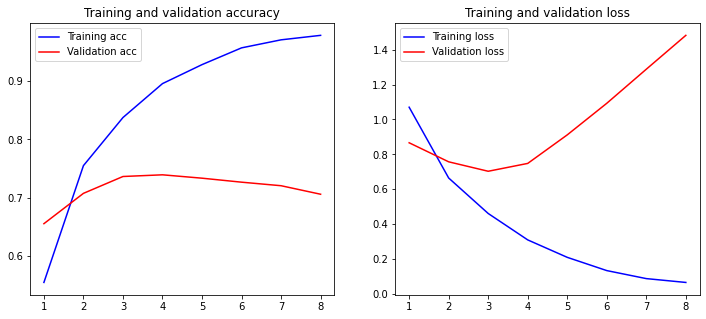

In [ ]:
plot_history(history)


In [14]:
keras.backend.clear_session()
model=keras.models.Sequential([
          keras.layers.Embedding(input_dim=num_tokens,
                                 output_dim=embading_dim,
                                 embeddings_initializer=keras.initializers.Constant(embading_matrix),
                                 trainable=True,
                                 input_length=max_length),
          keras.layers.GRU(128,return_sequences=True),
          keras.layers.GRU(128,return_sequences=True),
          keras.layers.GlobalMaxPool1D(),
          keras.layers.Dense(5,activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           13749600  
_________________________________________________________________
gru (GRU)                    (None, 40, 128)           165120    
_________________________________________________________________
gru_1 (GRU)                  (None, 40, 128)           99072     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 14,014,437
Trainable params: 14,014,437
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# this Function is for learning rate schedule 
# so the learning rate change depending of the val_loss
# this function is get better result than ReduceLROnPlateau function that come with keras

LR_START = 0.0000001
LR_MIN = 0.000001
LR_MAX = 0.0008
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lr_schedule(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr


In [15]:
model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(lr=1e-4),metrics=['accuracy'])
eraly_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)
check_point=keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/GRU_Learning_scheduler_20.h5',save_best_only=True)
lr_scdual=keras.callbacks.LearningRateScheduler(lr_schedule,verbose=0)
# reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 3,
#   verbose = 0, mode = "auto", min_delta = 1e-04, cooldown = 0,
#   min_lr = 1e-5)
callbacks_list=[eraly_stop,check_point,lr_scdual]


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
with tf.device('/device:GPU:0'):
  history=model.fit(X_train_set,y_train,epochs=20,validation_data=(X_val_set,y_val),callbacks=callbacks_list)

In [ ]:
model=keras.models.load_model('/content/drive/MyDrive/GRU_Learning_scheduler.h5')
loss,acc=model.evaluate(X_train_set,y_train)
print('Accuracy : {:.4f}'.format(acc))
loss,acc=model.evaluate(X_test_set,y_test)
print('Accuracy : {:.4f}'.format(acc))

823/823 [==============================] - 4s 5ms/step - loss: 0.2508 - accuracy: 0.9225
Accuracy : 0.9225
258/258 [==============================] - 1s 5ms/step - loss: 0.6057 - accuracy: 0.7903
Accuracy : 0.7903


# Note 
The following cell have model that create using keras API Models 
for mask issuse 

its the same as old model but we add mask for ignor *0* wich is the value of padding 
in other word ignor the padding token

In [11]:

keras.backend.clear_session()
K = keras.backend
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z=keras.layers.Embedding(input_dim=num_tokens,
                                 output_dim=embading_dim,
                                 embeddings_initializer=keras.initializers.Constant(embading_matrix),
                                 trainable=True,
                                 input_length=max_length)(inputs)
z = keras.layers.GRU(128,return_sequences=True)(z,mask=mask)
z = keras.layers.GRU(128,return_sequences=True)(z,mask=mask)
z = keras.layers.GlobalMaxPool1D()(z)
outputs=keras.layers.Dense(5,activation='softmax')(z)
Model=keras.Model(inputs=[inputs],outputs=[outputs])

In [12]:
Model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(lr=1e-4),metrics=['accuracy'])
eraly_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
check_point=keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/GRU_Learning_scheduler_20.h5',save_best_only=True)
#lr_scdual=keras.callbacks.LearningRateScheduler(lr_schedule,verbose=0)
reduce_lr =  keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 3,
  verbose = 0, mode = "auto", min_delta = 0.0008, cooldown = 0,
  min_lr = 1e-5)
callbacks_list=[eraly_stop,check_point,reduce_lr]


In [13]:
with tf.device('/device:GPU:0'):
  history=Model.fit(X_train_set,y_train,epochs=20,validation_data=(X_val_set,y_val),callbacks=callbacks_list)

Epoch 1/20
823/823 [==============================] - 123s 140ms/step - loss: 1.4978 - accuracy: 0.3298 - val_loss: 1.1850 - val_accuracy: 0.4931
Epoch 2/20
823/823 [==============================] - 117s 142ms/step - loss: 1.1043 - accuracy: 0.5403 - val_loss: 1.0113 - val_accuracy: 0.5885
Epoch 3/20
823/823 [==============================] - 113s 137ms/step - loss: 0.9127 - accuracy: 0.6464 - val_loss: 0.9125 - val_accuracy: 0.6483
Epoch 4/20
823/823 [==============================] - 112s 137ms/step - loss: 0.7962 - accuracy: 0.7063 - val_loss: 0.8755 - val_accuracy: 0.6637
Epoch 5/20
823/823 [==============================] - 113s 137ms/step - loss: 0.7012 - accuracy: 0.7490 - val_loss: 0.8174 - val_accuracy: 0.6963
Epoch 6/20
823/823 [==============================] - 113s 137ms/step - loss: 0.6197 - accuracy: 0.7949 - val_loss: 0.7869 - val_accuracy: 0.7097
Epoch 7/20
823/823 [==============================] - 113s 137ms/step - loss: 0.5417 - accuracy: 0.8233 - val_loss: 0.7851 -

In [16]:
loss,acc=Model.evaluate(X_train_set,y_train,verbose=False)
print('Accuracy : {:.4f}'.format(acc))
loss,acc=Model.evaluate(X_test_set,y_test,verbose=False)
print('Accuracy : {:.4f}'.format(acc))

Accuracy : 0.9095
Accuracy : 0.7206


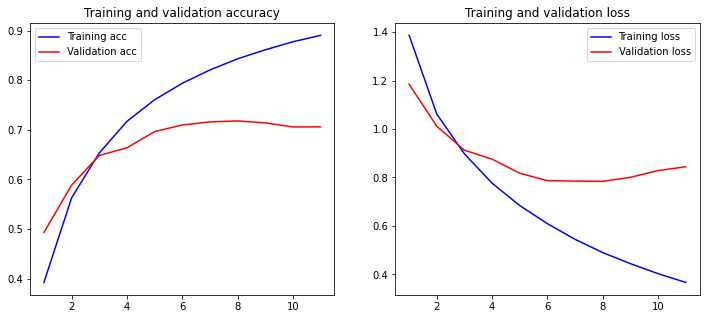

In [17]:
plot_history(history)